In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from forex.pre_training_data_prep.config import config

In [2]:
config

{'database_name': 'django',
 'dag_id': 'NEW_prepare_forex_data',
 'list_data_columns': ['return', 'volatility', 'volume', 'lhc_mean'],
 'list_data_columns_no_scale': ['sin_24', 'cos_24'],
 'n_back': 180,
 'n_forward': 30,
 'offset': 1,
 'n_step': 10,
 'tz_name': 'US/Eastern',
 'price_type_name': 'mid',
 'instrument_name': 'EUR/USD',
 'interval_name': 'Minute',
 'retries_pull_forex_data': 1,
 'retry_delay_minutes_pull_forex_data': 5,
 'cutoff_max_consec_nans': 2,
 'cutoff_total_nan_count': 5,
 'shuffle_random_seed': 42,
 'train_val_test_split': [0.7, 0.15, 0.15],
 'shuffle_X_train_and_val': True,
 'directory_output': '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output',
 'filename_candlesticks_query_results': 'candlesticks_query_results.parquet',
 'filename_timezone_added': 'candlesticks_timezone_added.parquet',
 'filename_offset': 'candlesticks_timezone_weekday_offset.parquet',
 'filename_weekday_shift_merged': 'candlesticks_w

In [3]:
filename_train_val_test_dict = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output/n_back_equals_180/dict_final_numpy.pickled'

In [4]:
import datetime
import pytz

class TimeSeries():

    def __init__(
        self,
        filename_train_val_test_dict,
        config,
        stat_function = None,
    ):

        with open(filename_train_val_test_dict, 'rb') as fff:
            train_val_test_dict = pickle.load(fff)

        self.config = config
        self.features_list = train_val_test_dict['features']['features_list']
        self.features_name_to_index = train_val_test_dict['features']['features_index_lookup']['name_to_index']
        self.features_index_to_name = train_val_test_dict['features']['features_index_lookup']['index_to_name']
        self.matrices = train_val_test_dict['matrices']
        self.timestamps = train_val_test_dict['list_of_timestamps']
        self.stat_function = stat_function
       
        # need to refactor this:
        self.stat_function_to_name_map = {
            np.mean : 'Mean',
            np.median : 'Median',
        }

        # need to refactor this too (maybe):
        if self.stat_function != None:
            self.apply_stat_function_to_y()

    def apply_stat_function_to_y(self):
        y_stat_dict = {}
        for set_name in ['train', 'test', 'val']:
            y_stat_dict[set_name] = (
                self.stat_function(self.matrices[set_name]['y'], axis = 1)
            )
        self.y_stat_dict = y_stat_dict
    
    def get_feature_index_from_feature_name(self, feature_name = 'lhc_mean'):
        return self.features_name_to_index[feature_name]
    
    def get_X_for_a_row(self, set_name = 'train', feature_name = 'lhc_mean', row_index = 0):
        return self.matrices[set_name]['X'][row_index, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]

    def get_y_for_a_row(self, set_name = 'train', feature_name = 'lhc_mean', row_index = 0):
        return self.matrices[set_name]['y'][row_index, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]

    def get_y_summary_statistic_array(self, set_name = 'train', feature_name = 'lhc_mean', function = np.mean):
        y_temp = self.matrices[set_name]['y'][:, :, self.get_feature_index_from_feature_name(feature_name = feature_name)]
        return function(y_temp, axis = 1)
    
    def plot_it(
        self,
        index_panel = 0,
        feature_name = 'lhc_mean',
        summary_statistic_function = np.mean,
        y_predicted = None,
        marker = 'o',
        markersize = 8,
    ):

        static_function_name = self.stat_function_to_name_map[summary_statistic_function]
        
        X_test = self.get_X_for_a_row(set_name = 'test', feature_name = feature_name, row_index = index_panel)
        y_test = self.get_y_for_a_row(set_name = 'test', feature_name = feature_name, row_index = index_panel)

        X_range = np.arange(0, config['n_back'])
        y_range = np.arange(config['n_back'], (config['n_back'] + config['n_forward']))

        #labels_xticks = list(X_range - config['n_back'])
        #labels_xticks.extend(list(y_range - config['n_back']))
        #labels_xticks = np.array(labels_xticks)
        #labels_xticks = labels_xticks[::10]  # hard coded
        #xticks = labels_xticks + config['n_back']


        
        y_summary_statistic_value = self.get_y_summary_statistic_array(set_name = 'test', feature_name = feature_name)[index_panel]


        from matplotlib.colors import TABLEAU_COLORS, same_color
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        
        
        plt.figure()
        plt.plot(X_range, X_test, label = 'Known X', color = colors[0])
        plt.plot(y_range, y_test, label = 'Known Y', color = colors[1])
        
        plt.plot(y_range, [y_summary_statistic_value] * config['n_forward'], label = static_function_name + '(Known Y)', color = colors[2])
        if y_predicted != None:
            if len(model_result.y_predicted[0]) == 1:
                y_predicted_value = y_predicted[0]
                plt.plot(y_range, [y_predicted_value] * config['n_forward'], label = 'Predicted Mean Y', color = colors[3])
        
        
        
        
        plt.plot([config['n_back']], y_test[0], marker = marker, markersize = markersize, label = 'Trade Execution Time', color = 'black')
        
        plt.ylabel(feature_name.replace('_', ' ') + ' (scaled)')
        plt.xlabel('Minutes')
        #plt.xticks(ticks = xticks, labels = labels_xticks)
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

In [5]:
ts = TimeSeries(filename_train_val_test_dict, config, stat_function = np.mean)

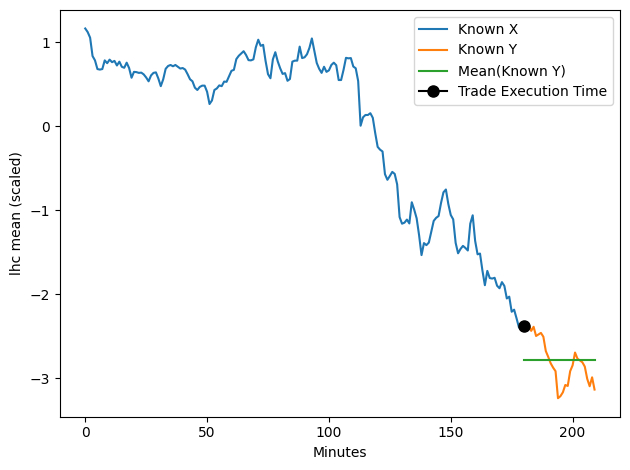

In [6]:
ts.plot_it(index_panel = 2000)

In [7]:
import pickle
import json
import pprint as pp
import numpy as np

from tensorflow.keras.models import model_from_json

#from plotting_utilities import plot_basic_loss
# instead
import matplotlib.pyplot as plt

2025-03-16 19:04:34.099439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 19:04:34.130725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-16 19:04:34.130749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-16 19:04:34.131583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 19:04:34.136793: I tensorflow/core/platform/cpu_feature_guar

In [8]:
application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output'

In [9]:
#training_run = 'blah----9101c2e0-43cb-4a70-9aff-8680f73edf62'
training_run = 'blah----d2707bf6-0b59-44ae-acaf-bfbe32276743'  # mean, three hours back


In [10]:
class ModelResult():
    def __init__(
        self,
        model_training_output_directory,
        training_run,
        timeseries,
        feature_name = 'lhc_mean',
    ):
        self.model_training_output_directory = model_training_output_directory
        self.training_run = training_run
        self.filename_history = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'
        self.filename_config_json = model_training_output_directory + '/' + training_run + '_lstm_regressor_config.json'
        self.filename_model_json = model_training_output_directory + '/' + training_run + '_model_regressor.json'
        self.filename_model_final_weights = model_training_output_directory + '/' + training_run + '_final_weights_regressor.pickled'
        self.train_val_test_data = timeseries
        self.feature_name = feature_name

    def fit(self):
        self.load_model()
        self.load_training_run_config()
        self.load_training_history()
        self.predict()
        self.compute_error()
    
    def load_model(self):
        with open(self.filename_model_json, 'r') as json_file:
            loaded_model_json = json_file.read()

        # Create a new model from the JSON
        self.model = model_from_json(loaded_model_json)

        # Load the weights into the new model
        self.model.load_weights(self.filename_model_final_weights)

    def load_training_history(self):
        try:
            with open(self.filename_history, 'rb') as ff:
                self.history = pickle.load(ff)
        except Exception as exception:
            print(exception)
            sys.exit(-1)
        
    def load_training_run_config(self):
        with open(self.filename_config_json) as ff:
            self.config = json.load(ff)

    def print_training_run_config(self):
        pp.pprint(self.config)
    
    def print_model_summary(self):
        self.model.summary()

    #
    # Define a function for plotting loss/mse against
    # validation loss/mse per training epoch
    #
    def plot_basic_loss(self, metric_base = 'loss', ylabel = 'Loss'):
        epochs = range(1, len(self.history[metric_base]) + 1)

        plt.figure()
        plt.plot(epochs, self.history[metric_base], '-.', label = ylabel)
        plt.plot(epochs, self.history['val_' + metric_base], '-.', label = 'Validation ' + ylabel)
        plt.xlabel('Training Epoch')
    
        plt.ylabel(ylabel)
        plt.title('Training Run: ' + self.training_run.split('----')[-1] + '\nBatch Size = ' + str(self.config['batch_size']))
    
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    def predict(self, set_name = 'test'):
        X_to_predict_y_response_for = ts.matrices[set_name]['X']
        self.y_predicted = self.model.predict(X_to_predict_y_response_for)

    
    def compute_error(self, feature_name = 'lhc_mean', set_name = 'test'):
        ts = self.train_val_test_data
        feature_index = ts.features_name_to_index[feature_name]
        y_known = ts.matrices[set_name]['y'][:, :, feature_index]

        if self.y_predicted.shape[1] == 1:
            y_predicted = self.y_predicted
            y_known = np.expand_dims(ts.y_stat_dict[set_name][:, feature_index], axis = 1)
            self.error_metric = (np.sum((y_known - y_predicted) ** 2)) / y_predicted.shape[0]
        elif self.y_predicted.shape[1] == ts.config['n_forward']:
            pass  # implement this later
        else:
            pass # send an error message or something, or create code to work with this possibility

    
    def plot_error_histogram(self):
        title_data = self.training_run.split('----')[0]
        title_run = self.training_run.split('----')[-1]
        title = 'Training data: ' + title_data + '\n' + 'Training run: ' + title_run
        
        plt.figure()
        plt.hist(self.error_prediction, bins=30, color = 'lightblue', label = 'Error metric distribution across test set')
        plt.axvline(x = self.error_prediction_median, color = 'magenta', label = 'Median')
        plt.xlabel('Count')
        plt.ylabel('Error Metric')
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_a_prediction(
        self,
        index_panel = 0,
        feature_name = 'lhc_mean',
    ):

        self.train_val_test_data.plot_it(
            index_panel = index_panel,
            feature_name = 'lhc_mean',
            y_predicted = self.y_predicted[index_panel],
        )

In [11]:
model_result = ModelResult(model_training_output_directory, training_run, ts)
model_result.fit()

2025-03-16 19:05:05.705071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6341 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5
2025-03-16 19:05:05.841106: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


388/388 [==============================] - 70s 177ms/step


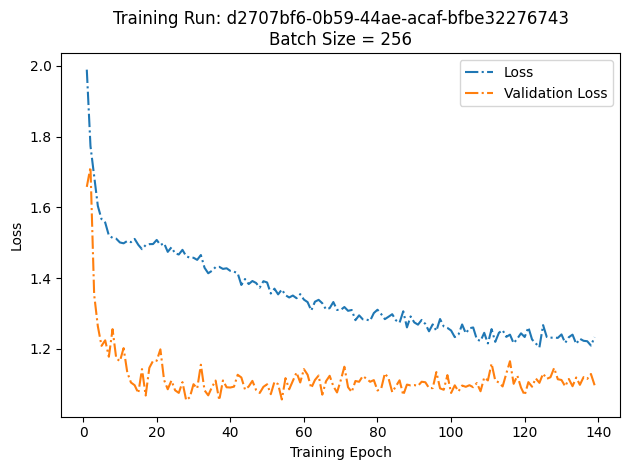

In [12]:
model_result.plot_basic_loss()

In [13]:
#model_result.plot_error_histogram()

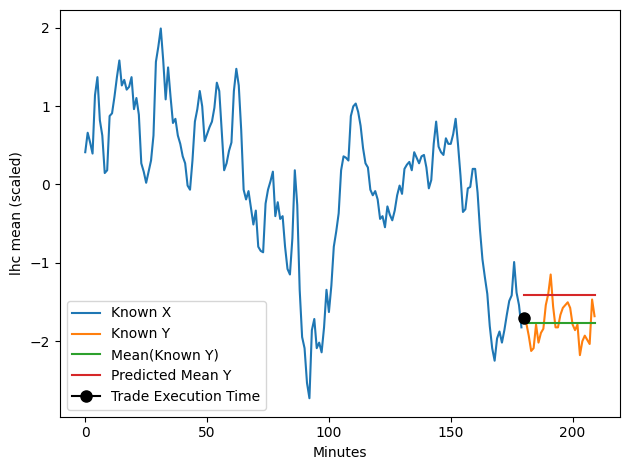

In [14]:
model_result.plot_a_prediction(index_panel = 1700)

In [23]:
def compute_error(model_result, feature_name = 'lhc_mean', set_name = 'test'):

    ts = model_result.train_val_test_data
    
    feature_index = ts.features_name_to_index[feature_name]
    y_known = ts.matrices[set_name]['y'][:, :, feature_index]

    if model_result.y_predicted.shape[1] == 1:
        y_predicted = model_result.y_predicted
        y_known = np.expand_dims(ts.y_stat_dict[set_name][:, feature_index], axis = 1)
        model_result.error_metric = (np.sum((y_known - y_predicted) ** 2)) / y_predicted.shape[0]

    elif model_result.y_predicted.shape[1] == ts.config['n_forward']:
        pass  # implement this later
    
    else:
        pass # send an error message or something, or create code to work with this possibility

    

error_metric = compute_error(model_result)

In [24]:
print(model_result.error_metric)

1.1213096426769333
